# Tensor Core 编程教程

在课程中，我们使用 `tmm` 内在函数来演示 `Tensorize` 的进展。 在本教程中，我们将把 TensorIR 运用到 NVIDIA GPU 上的 Tensor Cores。 请注意，Tensor Cores仅在具有 Volta 或更新架构的 NVIDIA GPU 上受支持（例如，`V100`、`T4`、`RTX-20X0`、`A100`、`RTX-30X0`）。 不幸的是，Colab 提供的大多数 GPU 都太旧，无法支持 Tensor Core。 您可能需要为本教程准备自己的设备。

## 什么是 Tensor Core？

张量核心是具有 Volta 和更新架构的 GPU 上的可编程矩阵乘法和累加单元。 每个 Tensor Core 都提供了一个矩阵处理数组，它执行 `D = A * B + C` 运算，如果我们使用 `nvcuda::wmma`，则`A`、`B`、`C` 和 `D` 是 `16x16` 的矩阵。 其中，矩阵乘法输入 `A` 和 `B` 是 `fp16` 矩阵，而累加矩阵 `C` 和 `D` 可以是 `fp16` 或 `fp32` 矩阵。

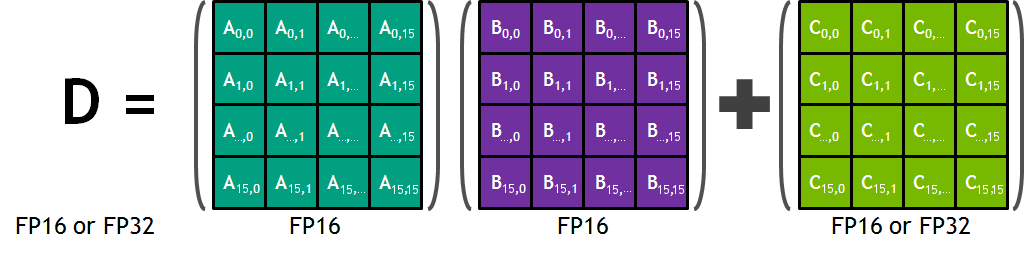

CUDA 语言只能使用 `warp-level` 原语 `wmma::mma_sync(acc_frag, a_frag, b_frag, acc_frag)` 在 Tensor Core 上执行 `16x16x16` 半精度矩阵乘法。 在调用矩阵乘法之前，我们必须使用原始的 `wmma::load_matrix_sync` 显式地将数据从内存加载到寄存器中（类似于我们在第6章第2部分的 `tmm` 演示中所做的）。 NVCC 编译器将该原语转换为多个内存加载指令。 在运行时，每个线程从矩阵 `A` 加载 16 个元素或从 `B` 加载 16 个元素。

## 准备工作

In [1]:
import tvm
from tvm.script import tir as T
from tvm import tir

import numpy as np

### 编写 Matmul 的 Tensor IR 程序

In [2]:
@tvm.script.ir_module
class MatmulModule:
    @T.prim_func
    def main(
        X: T.Buffer[(1024, 1024), "float16"],
        Y: T.Buffer[(1024, 1024), "float16"],
        Z: T.Buffer[(1024, 1024), "float32"],
    ) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(1024, 1024, 1024):
            with T.block("matmul"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Z[vi, vj] = T.float32(0)
                Z[vi, vj] += T.cast(X[vi, vk], "float32") * T.cast(Y[vj, vk], "float32")

注意计算 `Z[vi, vj] += T.cast(X[vi, vk], "float32") * T.cast(Y[vj, vk], "float32")` 与常规表示有点不同。 由于 Tensor Cores 加载 `fp16` 的数据，但在 `fp32` 进行计算。 所以我们必须在计算之前将数据 `cast` 到`fp32`。

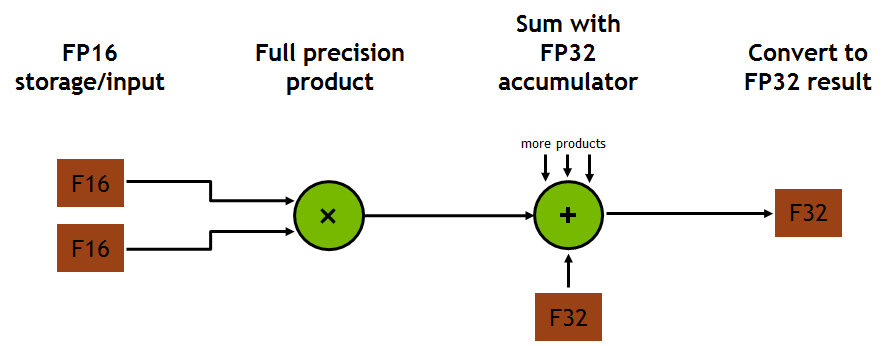

## 内存层级

在传统的 GPU 调度中，我们有 “全局内存”、“共享内存”和“本地寄存器”的内存层级。 为了支持 Tensor Cores，我们引入了另外三个特殊的内存范围：`wmma.matrix_a`、`wmma.matrix_b` 和 `wmma.accumulator`（类似于在第 6 章第 2 部分的演示中的 `global.A_reg`、`global.B_reg` 和 `global. accumulator`）。 在硬件上，所有 `wmma` 的内存相关层级都存储在片上寄存器级别，与本地内存相同。

## 注册 Tensor Intrinsic

这里我们注册了所有的 Tensor Core intrinsics，包括`load_matrix_a`、`load_matrix_b`、`wmma_fill`（初始化`C = 0`）、`wmma_sync`（累加计算`C += A * B`）和 `store_matrix`。 在本教程中，我们不会解释如何编写 intrinsic ，而是关注如何将给定的 intrinsic 应用于张量化程序。

In [3]:
@T.prim_func
def wmma_load_a_desc(a: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (16, 16), "float16", align=128, offset_factor=16, scope="shared")
    C = T.match_buffer(c, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_a")

    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        for i, j in T.grid(16, 16):
            with T.block("load"):
                vii, vjj = T.axis.remap("SS", [i, j])
                C[vii, vjj] = A[vii, vjj]


@T.prim_func
def wmma_load_a_impl(a: T.handle, c: T.handle) -> None:
    s1 = T.var("int32")
    s0 = T.var("int32")
    A = T.match_buffer(
        a,
        (16, 16),
        "float16",
        align=128,
        offset_factor=16,
        scope="shared",
        strides=[s1, s0],
    )
    C = T.match_buffer(c, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_a")

    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.tvm_load_matrix_sync(
                C.data,
                16,
                16,
                16,
                C.elem_offset // 256 + T.floordiv(T.floormod(C.elem_offset, 256), 16),
                A.access_ptr("r"),
                s1,
                "row_major",
                dtype="handle",
            )
        )


@T.prim_func
def wmma_load_b_desc(a: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (16, 16), "float16", align=128, offset_factor=16, scope="shared")
    C = T.match_buffer(c, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_b")

    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        for i, j in T.grid(16, 16):
            with T.block("load"):
                vii, vjj = T.axis.remap("SS", [i, j])
                C[vii, vjj] = A[vii, vjj]


@T.prim_func
def wmma_load_b_impl(a: T.handle, c: T.handle) -> None:
    s1 = T.var("int32")
    s0 = T.var("int32")
    A = T.match_buffer(
        a,
        (16, 16),
        "float16",
        align=128,
        offset_factor=16,
        scope="shared",
        strides=[s1, s0],
    )
    C = T.match_buffer(c, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_b")

    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.tvm_load_matrix_sync(
                C.data,
                16,
                16,
                16,
                C.elem_offset // 256 + T.floordiv(T.floormod(C.elem_offset, 256), 16),
                A.access_ptr("r"),
                s1,
                "col_major",
                dtype="handle",
            )
        )


@T.prim_func
def wmma_sync_desc(a: T.handle, b: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_a")
    B = T.match_buffer(b, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_b")
    C = T.match_buffer(
        c, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )

    with T.block("root"):
        T.reads(C[0:16, 0:16], A[0:16, 0:16], B[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        for i, j, k in T.grid(16, 16, 16):
            with T.block(""):
                vii, vjj, vkk = T.axis.remap("SSR", [i, j, k])
                C[vii, vjj] += T.cast(A[vii, vkk], "float32") * T.cast(B[vjj, vkk], "float32")


@T.prim_func
def wmma_sync_impl(a: T.handle, b: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_a")
    B = T.match_buffer(b, (16, 16), "float16", align=128, offset_factor=16, scope="wmma.matrix_b")
    C = T.match_buffer(
        c, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )

    with T.block("root"):
        T.reads(C[0:16, 0:16], A[0:16, 0:16], B[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.tvm_mma_sync(
                C.data,
                C.elem_offset // 256 + T.floordiv(T.floormod(C.elem_offset, 256), 16),
                A.data,
                A.elem_offset // 256 + T.floordiv(T.floormod(A.elem_offset, 256), 16),
                B.data,
                B.elem_offset // 256 + T.floordiv(T.floormod(B.elem_offset, 256), 16),
                C.data,
                C.elem_offset // 256 + T.floordiv(T.floormod(C.elem_offset, 256), 16),
                dtype="handle",
            )
        )


@T.prim_func
def wmma_fill_desc(c: T.handle) -> None:
    C = T.match_buffer(
        c, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )

    with T.block("root"):
        T.reads()
        T.writes(C[0:16, 0:16])
        for i, j in T.grid(16, 16):
            with T.block("init"):
                vii, vjj = T.axis.remap("SS", [i, j])
                C[vii, vjj] = T.float32(0)


@T.prim_func
def wmma_fill_impl(c: T.handle) -> None:
    C = T.match_buffer(
        c, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )
    with T.block("root"):
        T.reads()
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.tvm_fill_fragment(
                C.data,
                16,
                16,
                16,
                C.elem_offset // 256 + T.floordiv(T.floormod(C.elem_offset, 256), 16),
                T.float32(0),
                dtype="handle",
            )
        )


@T.prim_func
def wmma_store_desc(a: T.handle, c: T.handle) -> None:
    A = T.match_buffer(
        a, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )
    C = T.match_buffer(c, (16, 16), "float32", align=128, offset_factor=16, scope="global")
    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        for i, j in T.grid(16, 16):
            with T.block("store"):
                vii, vjj = T.axis.remap("SS", [i, j])
                C[vii, vjj] = A[vii, vjj]


@T.prim_func
def wmma_store_impl(a: T.handle, c: T.handle) -> None:
    s1 = T.var("int32")
    s0 = T.var("int32")
    A = T.match_buffer(
        a, (16, 16), "float32", align=128, offset_factor=16, scope="wmma.accumulator"
    )
    C = T.match_buffer(
        c,
        (16, 16),
        "float32",
        align=128,
        offset_factor=16,
        scope="global",
        strides=[s1, s0],
    )
    with T.block("root"):
        T.reads(A[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.tvm_store_matrix_sync(
                A.data,
                16,
                16,
                16,
                A.elem_offset // 256 + T.floordiv(T.floormod(A.elem_offset, 256), 16),
                C.access_ptr("w"),
                s1,
                "row_major",
                dtype="handle",
            )
        )


try:
    # handle exception if we register multi times
    tir.TensorIntrin.register("wmma_load_a", wmma_load_a_desc, wmma_load_a_impl)
    tir.TensorIntrin.register("wmma_load_b", wmma_load_b_desc, wmma_load_b_impl)
    tir.TensorIntrin.register("wmma_sync", wmma_sync_desc, wmma_sync_impl)
    tir.TensorIntrin.register("wmma_fill", wmma_fill_desc, wmma_fill_impl)
    tir.TensorIntrin.register("wmma_store", wmma_store_desc, wmma_store_impl)
except ValueError:
    pass

## Blockize 张量计算

正如课程中所说，我们可以使用 TensorIR 来表示一组带有 `Block` 的张量化计算。 我们可以直接用 `Block` 编写一个 TensorIR 程序，也可以通过`blockize` 生成新的 `block`。 请记住，`wmma` 操作适用于 `16x16x16` 矩阵乘法，我们需要切分循环，而最里面的循环是 `16x16x16`。

In [4]:
sch = tir.Schedule(MatmulModule)
block = sch.get_block("matmul")
i, j, k = sch.get_loops(block)

i, ii = sch.split(i, factors=[None, 16])
j, ji = sch.split(j, factors=[None, 16])
k, ki = sch.split(k, factors=[None, 16])
sch.reorder(i, j, k, ii, ji, ki)
wmma_sync = sch.blockize(loop=ii)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0, j_0, k_0 in T.grid(64, 64, 64):
            with T.block("matmul_o"):
                vi_o, vj_o, vk_o = T.axis.remap("SSR", [i_0, j_0, k_0])
                T.reads(X[vi_o * 16 : vi_o * 16 + 16, vk_o * 16 : vk_o * 16 + 16], Y[vj_o * 16 : vj_o * 16 + 16, vk_o * 16 : vk_o * 16 + 16])
                T.writes(Z[vi_o * 16 : vi_o * 16 + 16, vj_o * 16 : vj_o * 16 + 16])
                with T.init():
                    for i_1, j_1 in T.grid(16, 16):
                        with T.block("matmul_init"):
                            vi_i_init, vj_i_init = T.axis.remap("SS", [i_1, j_1])
                            T.r

## 切分循环并绑定 threadIdx

### Warp 指令
请注意，所有 Tensor Core 指令都是 warp 指令，这意味着一个 warp 中的所有 32 个线程应该同时执行此指令。 使 `threadIdx.x` extent=32 是解决此问题的最简单方法之一。 然后我们可以将`threadIdx.x`绑定到任何循环**除了**那些直接或间接包含Tensor Core内在函数的循环。 另请注意，这不是唯一的解决方案。 我们唯一应该做的就是确保一个 warp 中的所有线程都可以同时调用 Tensor Core。

In [5]:
i0, i1, i2 = sch.split(i, factors=[8, 4, 2])
j0, j1, j2 = sch.split(j, factors=[8, 4, 2])
k0, k1, k2 = sch.split(k, factors=[16, 2, 2])

sch.reorder(i0, j0, i1, j1, k0, k1, i2, j2, k2)
bx = sch.fuse(i0, j0)
sch.bind(bx, "blockIdx.x")
ty = sch.fuse(i1, j1)
sch.bind(ty, "threadIdx.y")
# We can't bind to `threadIdx.x` since we have warp-level operators under the loop
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
                for k_0_0, k_0_1, i_0_2, j_0_2, k_0_2 in T.grid(16, 2, 2, 2, 2):
                    with T.block("matmul_o"):
                        vi_o = T.axis.spatial(64, i_0_0_j_0_0_fused // 8 * 8 + i_0_1_j_0_1_fused // 4 * 2 + i_0_2)
                        vj_o = T.axis.spatial(64, i_0_0_j_0_0_fused % 8 * 8 + i_0_1_j_0_1_fused % 4 * 2 + j_0_2)
                        vk_o = T.axis.reduce(64, k_0_0 * 4 + k_0_1 * 2 + k_0_2)
                        T.reads(X[vi_o * 1

## 将`A`和`B`缓存到共享内存中

与 Cuda Cores 的优化技巧类似，我们仍然需要将 `A` 和 `B` 缓存到共享内存中。 此外，还需要利用 cooperative fetching 技术。

In [6]:
X_shared = sch.cache_read(wmma_sync, read_buffer_index=0, storage_scope="shared")
Y_shared = sch.cache_read(wmma_sync, read_buffer_index=1, storage_scope="shared")


def schedule_shared(block):
    sch.compute_at(block, k0)
    x, y = sch.get_loops(block)[-2:]
    fused = sch.fuse(x, y)
    x0, x1, x2, x3 = sch.split(fused, factors=[None, 16, 32, 8])
    sch.bind(x1, "threadIdx.y")
    # here we must bind threadIdx.x == 32 to satisfy the requirements of warp-level operation.
    sch.bind(x2, "threadIdx.x") 
    sch.vectorize(x3)


schedule_shared(X_shared)
schedule_shared(Y_shared)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
                for k_0_0 in T.serial(16):
                    for ax0_ax1_fused_0 in T.serial(2):
                        for ax0_ax1_fused_1 in T.thread_binding(16, thread="threadIdx.y"):
                            for ax0_ax1_fused_2 in T.thread_binding(32, thread="threadIdx.x"):
                              

## 将输入输出数据缓存到特殊内存层级

Tensor Cores 不能直接使用共享内存或本地内存中的数据。 我们必须将数据缓存到 `wmma.matrix_a`、`wmma.matrix_b` 并更新 `wmma.accumulator` 中的计算。

### 缓存输入数据

In [7]:
X_local = sch.cache_read(wmma_sync, 0, storage_scope="wmma.matrix_a")
Y_local = sch.cache_read(wmma_sync, 1, storage_scope="wmma.matrix_b")
sch.compute_at(X_local, k1)
sch.compute_at(Y_local, k1)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        X_shared_wmma_matrix_a = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_a")
        Y_shared_wmma_matrix_b = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_b")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
                for k_0_0 in T.serial(16):
                    for ax0_ax1_fused_0 in T.serial(2):
            

### 缓存输出数据

In [8]:
write_back_block = sch.cache_write(wmma_sync, 0, storage_scope="wmma.accumulator")
sch.reverse_compute_at(write_back_block, ty)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        X_shared_wmma_matrix_a = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_a")
        Y_shared_wmma_matrix_b = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_b")
        Z_wmma_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="wmma.accumulator")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
          

## 切分 Tensor Core 内存拷贝

`wmma.load_matrix` 和 `wmma.store_matrix` 使用 `16x16` 矩阵执行内存复制。 然后我们对循环进行切分，以此来匹配 intrinsic。

In [9]:
def schedule_copy(block):
    x, y = sch.get_loops(block)[-2:]
    x0, x1 = sch.split(x, factors=[None, 16])
    y0, y1 = sch.split(y, factors=[None, 16])
    sch.reorder(x0, y0, x1, y1)

schedule_copy(X_local)
schedule_copy(Y_local)
schedule_copy(write_back_block)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        X_shared_wmma_matrix_a = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_a")
        Y_shared_wmma_matrix_b = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_b")
        Z_wmma_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="wmma.accumulator")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
          

## Tensorize

tensorize 之前，我们需要先执行 `decompose_reduction`，因为 `wmma_sync` 和 `wmma_fill` 是两个 intrinsic，需要对 init block 和 update block 进行两次 tensorize


In [10]:
init = sch.decompose_reduction(wmma_sync, k0)
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        X_shared_wmma_matrix_a = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_a")
        Y_shared_wmma_matrix_b = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_b")
        Z_wmma_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="wmma.accumulator")
        for i_0_0_j_0_0_fused in T.thread_binding(64, thread="blockIdx.x"):
            for i_0_1_j_0_1_fused in T.thread_binding(16, thread="threadIdx.y"):
          

In [11]:
sch.tensorize(sch.get_loops(X_local)[-2], "wmma_load_a")
sch.tensorize(sch.get_loops(Y_local)[-2], "wmma_load_b")
sch.tensorize(init, "wmma_fill")
sch.tensorize(wmma_sync, "wmma_sync")
sch.tensorize(sch.get_loops(write_back_block)[-2], "wmma_store")
sch.mod.show()

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer[(1024, 1024), "float16"], Y: T.Buffer[(1024, 1024), "float16"], Z: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        s0 = T.var("int32")
        s0_1 = T.var("int32")
        s0_2 = T.var("int32")
        s1 = T.var("int32")
        s1_1 = T.var("int32")
        s1_2 = T.var("int32")
        # body
        # with T.block("root")
        X_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        Y_shared = T.alloc_buffer([1024, 1024], dtype="float16", scope="shared")
        X_shared_wmma_matrix_a = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_a")
        Y_shared_wmma_matrix_b = T.alloc_buffer([1024, 1024], dtype="float16", scope="wmma.matrix_b")
        Z_wmma_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="wmma.accum

## 构建并评估结果

In [12]:
rt_mod = tvm.build(sch.mod, target="cuda")

dev = tvm.cuda()
num_flop = 1024**3 * 2
A_np = np.random.randn(1024, 1024).astype("float16")
B_np = np.random.randn(1024, 1024).astype("float16")
C_np = A_np.astype("float32") @ (B_np.astype("float32").T)

A_nd = tvm.nd.array(A_np, dev)
B_nd = tvm.nd.array(B_np, dev)
C_nd = tvm.nd.array(np.empty((1024, 1024), dtype="float32"), dev)

rt_mod(A_nd, B_nd, C_nd)
np.testing.assert_allclose(C_np, C_nd.numpy(), rtol=1e-3, atol=1e-3)

evaluator = rt_mod.time_evaluator("main", dev, number=10)
print("Performance: %f GFLOPS" % (num_flop / evaluator(A_nd, B_nd, C_nd).mean / 1e9))

Performance: 23492.797289 GFLOPS


## 讨论

请考虑如何使这个程序运行得更快？（极限性能在 50T 左右，而这个程序在 RTX-3080 上只有 23T）

## 参考文献

https://developer.nvidia.com/blog/programming-tensor-cores-cuda-9/

https://tvm.apache.org/docs/how_to/optimize_operators/opt_conv_tensorcore.html